In [1]:
#!/usr/bin/env python

In [2]:
import os
import sys
if os.path.exists('/home/chieh/code/wPlotLib'):
	sys.path.insert(0,'/home/chieh/code/wPlotLib')
if os.path.exists('/home/chieh/code/wuML'):
	sys.path.insert(0,'/home/chieh/code/wuML')

In [3]:
import wuml
import numpy as np
import torch
import torch
import torch.nn as nn

In [4]:
def costFunction(x, x̂, ẙ, y, ŷ, ind):	
#	x -> encoder -> x̂
#	x̂ -> encoder_linear_output -> ẙ	
#	x̂ -> decoder -> ŷ	
#	possible autoencoder objective λ could be 0
#	loss = (x - ŷ)ᒾ + λ * objective(ẙ, y)
#
#	This function can return 1 value or 3 values in a list
#	if return 1 value, just the loss
#	if return 3 values, [total_loss, reconstruction_loss, extra network from ẙ loss]
#
#	In this example, we perform both reconstruction and CE loss
#
	CE_loss = nn.CrossEntropyLoss() #weird pytorch, dim of y is 1, and ŷ is 20x3
	R = torch.sum((x - ŷ) ** 2)/(128*11)	#scaled by batch size times data dimension
	mse = torch.sum((ẙ - y) ** 2)/(128)	#scaled by batch size times data dimension
	loss = R + mse
	return [loss, R, mse]

In [5]:
def costFunction2(x, x̂, ẙ, y, ŷ, ind):	
#	Example of just return 1 value, this is just a regular autoencoder
	return torch.sum((x - ŷ) ** 2)

In [6]:
data = wuml.wData('../../data/shap_regress_example_uniform.csv', label_column_name='label', label_type='continuous', 
				preprocess_data='center and scale',	first_row_is_label=True)

In [7]:
[X_train, X_test, y_train, y_test] = wuml.split_training_test(data, test_percentage=0.2)

In [8]:
AE = wuml.autoencoder(7, X_train, default_depth=2, costFunction=costFunction, # costFunction and costFunction2 both works
						max_epoch=1000, encoder_output_weight_structure=[(1,'none')] ) 
AE.fit()

	epoch: 1000, Total Loss/dimension: 0.4374, Reconstruct loss: 0.0146, Objective loss: 0.4228, Learning Rate: 0.00000098

Result of the data reconstruction

In [9]:
ŷ = AE(data)
print('\n\n')
recontructed = wuml.pretty_np_array(ŷ[0:5,0:5], front_tab='', title='recontruction')
original = wuml.pretty_np_array(data.X[0:5,0:5], front_tab=' ', title='original')
wuml.block_two_string_concatenate(recontructed, original, spacing='\t', auto_print=True)

This is the bottleneck output which is d=12

In [10]:
x̂ = AE.reduce_dimension(data, output_type='wData')
wuml.jupyter_print(x̂)
print('\n')

,0,1,2,3,4,5,6
0,0.692168,0.238576,-0.302232,1.107141,0.208717,0.289579,0.116262
1,-0.166590,-0.725461,0.944446,1.335740,-0.080951,0.829027,0.767283
2,-0.170615,0.999011,-1.203271,0.302971,0.645509,0.063847,1.197284
3,1.947343,0.849167,-0.905920,-0.600097,-0.364517,-0.422102,-1.440485
4,0.547533,-1.089884,1.244860,3.191465,0.290295,1.033538,0.209290
...,...,...,...,...,...,...,...
25,-1.237892,-0.316856,0.469902,1.186737,0.545123,0.808332,2.071631
26,0.351629,-0.289396,0.455938,1.552851,0.463467,0.447641,0.335163
27,0.756281,-0.922154,1.072191,2.081667,-0.306138,0.886827,-0.160459
28,-0.068931,0.857232,-0.939900,0.607070,0.968045,-0.019014,1.034454


This is the objective network output Training error

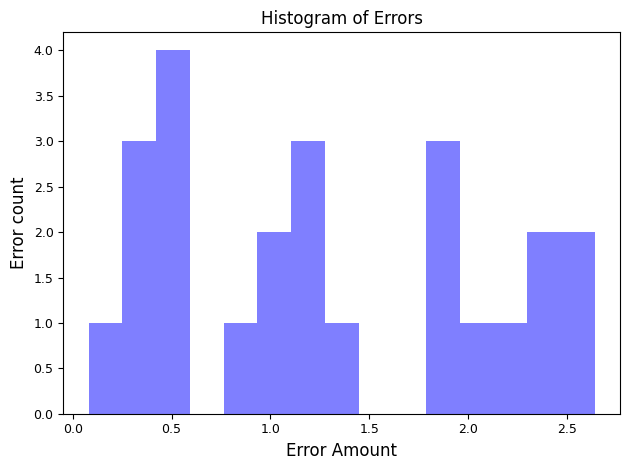

,y,ŷ,Δy
16,5.76,8.40,2.64
23,-8.05,-10.57,2.52
12,-5.72,-8.17,2.45
13,3.58,5.98,2.40
4,-7.50,-9.65,2.15
10,-5.67,-7.64,1.97
18,-4.35,-6.27,1.92
19,-4.14,-6.01,1.87
8,3.38,5.19,1.81
15,-3.27,-4.57,1.30


In [11]:
ẙ = AE.objective_network(X_train)
res = wuml.output_regression_result(y_train, ẙ, sort_by='error')

This is the objective network output Test error

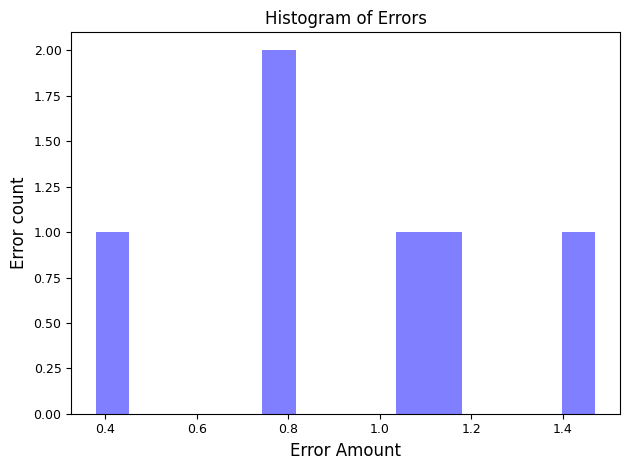

,y,ŷ,Δy
0,-5.91,-7.38,1.47
5,-2.31,-3.46,1.15
4,-2.61,-3.66,1.05
3,0.20,-0.56,0.76
2,-0.05,0.71,0.76
1,-0.21,-0.59,0.38


In [12]:
ẙ = AE.objective_network(X_test)
res = wuml.output_regression_result(y_test, ẙ, sort_by='error')